<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/progressive_resizing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training using progressive resizing

For more information about the progressive resizing technique, please check out the reference, here below:

Fastai Fastbook Chapter: https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb

Check out the section: **Progressive Resizing**

## Introduction

This tutorial walk you through the different steps of training the fridge dataset using the progressive resizing technique. 

IceVision Framework is an **agnostic framework**. As an illustration, we will train our model using both the [fastai](https://github.com/fastai/fastai) library, and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning) libraries.

## Installing IceVision and IceData

In [ ]:
# !pip install icevision[all] icedata
!pip install git+git://github.com/airctic/icevision.git#egg=icevision[all] icedata --upgrade

## Imports

In [ ]:
from icevision.all import *
from fastai.callback.tracker import SaveModelCallback

## Datasets : Fridge Objects dataset
Fridge Objects dataset is tiny dataset that contains 134 images of 4 classes:
- can, 
- carton, 
- milk bottle, 
- water bottle.

IceVision provides very handy methods such as loading a dataset, parsing annotations, and more. 

In [ ]:
# Loading Data
url = "https://cvbp.blob.core.windows.net/public/datasets/object_detection/odFridgeObjects.zip"
dest_dir = "fridge"
data_dir = icedata.load_data(url, dest_dir)

In [ ]:
# Parser
class_map = ClassMap(["milk_bottle", "carton", "can", "water_bottle"])
parser = parsers.voc(annotations_dir=data_dir / "odFridgeObjects/annotations",
                     images_dir=data_dir / "odFridgeObjects/images",
                     class_map=class_map)
# Records
train_records, valid_records = parser.parse()

INFO     - Autofixing records | icevision.parsers.parser:parse:124


### Visualization
Showing a batch of images with their corresponding boxes and labels

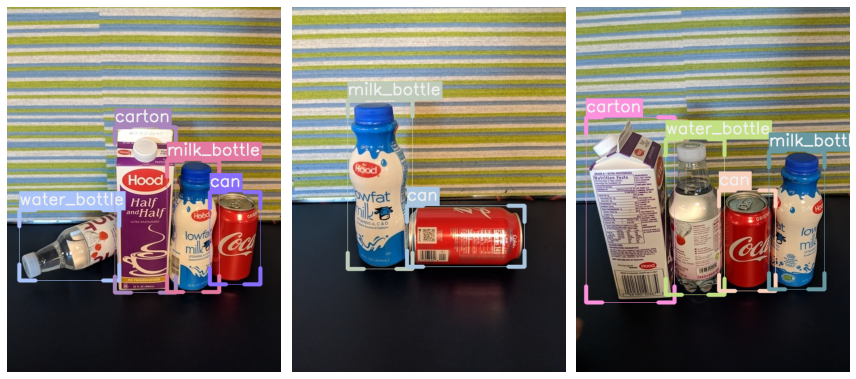

In [ ]:
show_records(train_records[:3], ncols=3, class_map=class_map)

## Train and Validation Dataset Transforms
The code, here below, corresponds to familiar code that we usually use in case we don't use the progressive resizing technique. We left it there for a sake of comparison as well as a reference.

In [ ]:
# Transforms
# train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=384, presize=512), tfms.A.Normalize()])
# valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(384), tfms.A.Normalize()])

In [ ]:
# Datasets
# train_ds = Dataset(train_records, train_tfms)
# valid_ds = Dataset(valid_records, valid_tfms)

## Method returning both Datasets and DataLoaders for a giving image size

In [ ]:
def get_dataloaders(model_type, size, presize):
    ds = []
    dls: Sequence[Union[DataLoader, fastai.DataLoader]] = []
    # Transforms
    valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])
    train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])

    # Datasets
    train_ds = Dataset(train_records, train_tfms)
    valid_ds = Dataset(valid_records, valid_tfms)

    # Dataloaders
    train_dl = model_type.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
    valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

    ds.append(train_ds)
    ds.append(valid_ds)

    dls.append(train_dl)
    dls.append(valid_dl)

    return (ds, dls)

In [ ]:
model_type = faster_rcnn
# model_type = retinanet

## Initial size: First size (size = 384)

In [ ]:
presize = 512
size = 384
(ds, dls) = get_dataloaders(model_type, size, presize)

### Displaying the same image with different transforms

Note:
> Transforms are applied **lazily**, meaning they are only applied when we grab (get) an item.
> This means that, if you have augmentation (random) transforms, each time you get the **same** item from 
> the dataset you will get a slightly different version of it.

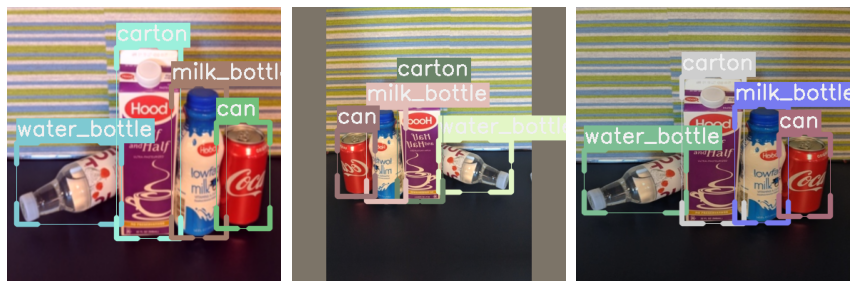

In [ ]:
samples = [ds[0][0] for _ in range(3)]
show_samples(samples, ncols=3, class_map=class_map)

In [ ]:
ds[0][0]['width'], ds[0][0]['height']

(384, 384)

## DataLoader

In [ ]:
# DataLoaders
# train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
# valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

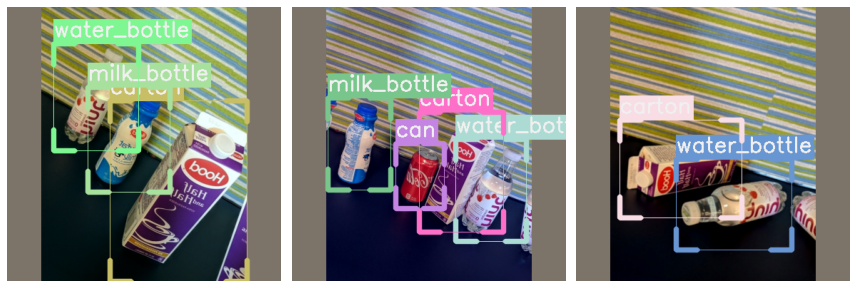

In [ ]:
batch, samples = first(dls[0])
show_samples(samples[:3], class_map=class_map, ncols=3)

In [ ]:
dls[0].dataset[0]['width'], dls[0].dataset[0]['height']

(384, 384)

## Model

In [ ]:
# Get a pretrained ResNeSt FPN Backbone: e.g restnest50 
# Existing pretrained resnest backbones are: resnest50, resnest101, resnest200, resnest269
backbone = backbones.resnet_fpn.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
model = model_type.model(backbone = backbone, num_classes=len(class_map))

## Metrics

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

## Training

IceVision is an agnostic framework meaning it can be plugged to other DL framework such as [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).  

You could also plug to oth DL framework using your own custom code.

### Training using fastai

In [ ]:
learn = model_type.fastai.learner(dls=dls, model=model, metrics=metrics, cbs=SaveModelCallback(monitor='COCOMetric'))

In [ ]:
learn.dls, learn.dls[0]

(<fastai.data.core.DataLoaders at 0x7efc0188b470>,
 <icevision.engines.fastai.adapters.convert_dataloader_to_fastai.convert_dataloader_to_fastai.<locals>.FastaiDataLoaderWithCollate at 0x7efc32a58518>)

SuggestedLRs(lr_min=0.0001737800776027143, lr_steep=0.02754228748381138)

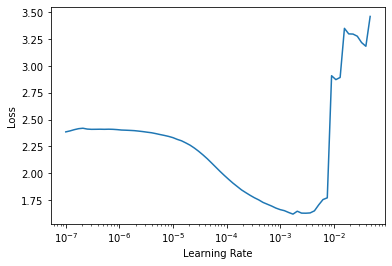

In [ ]:
learn.freeze()
learn.lr_find()

## First Pass: First Training with the size = 384

In [ ]:
learn.fine_tune(10, 2e-4, freeze_epochs=1)

epoch,train_loss,valid_loss,COCOMetric,time
0,1.836724,0.961724,0.000054,00:07


Better model found at epoch 0 with COCOMetric value: 5.401442517666116e-05.


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,COCOMetric,time
0,1.019728,0.911696,0.000028,00:09
1,1.033148,0.870583,0.063911,00:08
2,1.028278,0.780145,0.093786,00:07
3,0.971249,0.495171,0.132743,00:07
4,0.873244,0.353948,0.182261,00:07
5,0.792869,0.350753,0.212721,00:07
6,0.726154,0.388202,0.267017,00:07
7,0.678153,0.386464,0.240693,00:07
8,0.636668,0.392375,0.269355,00:07
9,0.606640,0.383781,0.283895,00:07


Better model found at epoch 0 with COCOMetric value: 2.8404889907503137e-05.
Better model found at epoch 1 with COCOMetric value: 0.06391108003733076.
Better model found at epoch 2 with COCOMetric value: 0.09378590221702382.
Better model found at epoch 3 with COCOMetric value: 0.13274282618736102.
Better model found at epoch 4 with COCOMetric value: 0.18226093568356258.
Better model found at epoch 5 with COCOMetric value: 0.21272099386549365.
Better model found at epoch 6 with COCOMetric value: 0.2670172220143836.
Better model found at epoch 8 with COCOMetric value: 0.2693551160382692.
Better model found at epoch 9 with COCOMetric value: 0.2838948760928852.


# Restart resizing from here

## Subsequent Pass: Subsequent Training with the size = 512

In [ ]:
# Second Pass (size = 512)
# presize = 640
# size = 512

# Third Pass (size = 640)
presize = 768
size = 640
(ds, dls) = get_dataloaders(model_type, size, presize)

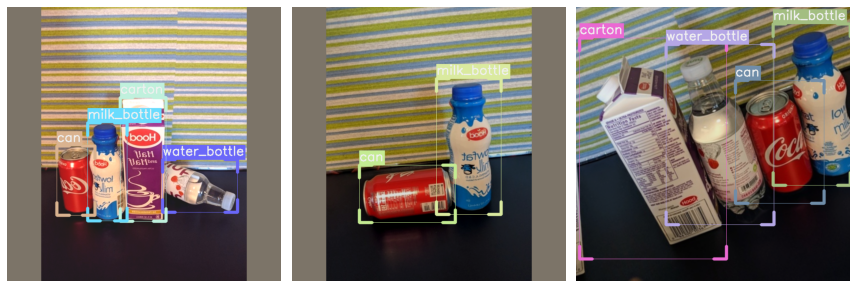

In [ ]:
samples = [ds[0][i] for i in range(3)]
show_samples(samples, ncols=3, class_map=class_map)

In [ ]:
ds[0][0]['width'], ds[0][0]['height']

(640, 640)

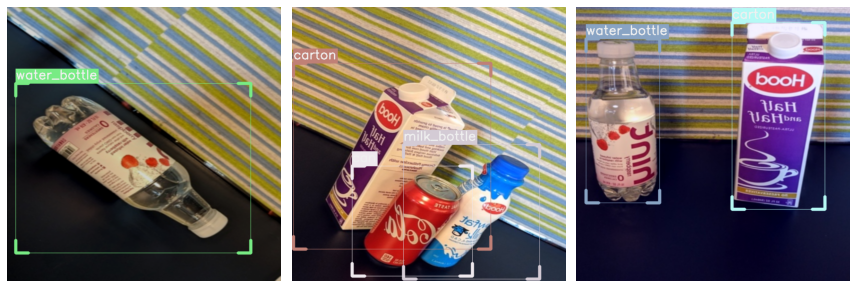

In [ ]:
batch, samples = first(dls[0])
show_samples(samples[:3], class_map=class_map, ncols=3)

In [ ]:
dls[0].dataset[0]['width'], dls[0].dataset[0]['height']

(640, 640)

## Convert Pytorch DataLoaders to Fastai DataLoaders

In [ ]:
fastai_dls = convert_dataloaders_to_fastai(dls=dls)

In [ ]:
fastai_dls[0]

<icevision.engines.fastai.adapters.convert_dataloader_to_fastai.convert_dataloader_to_fastai.<locals>.FastaiDataLoaderWithCollate at 0x7efc03235cf8>

In [ ]:
learn.dls = fastai_dls

In [ ]:
learn.dls[0]

<icevision.engines.fastai.adapters.convert_dataloader_to_fastai.convert_dataloader_to_fastai.<locals>.FastaiDataLoaderWithCollate at 0x7efc03235cf8>

In [ ]:
# learn.fine_tune(10, 2e-4, freeze_epochs=1)
learn.fit_one_cycle(10, 2e-4)

epoch,train_loss,valid_loss,COCOMetric,time
0,0.263216,0.218714,0.603113,00:18
1,0.260136,0.271683,0.507281,00:12
2,0.273679,0.214517,0.581040,00:12
3,0.268140,0.205312,0.646935,00:12
4,0.261781,0.210960,0.619102,00:12
5,0.251973,0.190831,0.642841,00:12
6,0.242301,0.161353,0.728151,00:12
7,0.231294,0.165412,0.728464,00:13
8,0.222239,0.154678,0.744886,00:12
9,0.213687,0.153505,0.746711,00:12


Better model found at epoch 0 with COCOMetric value: 0.6031128488701467.
Better model found at epoch 3 with COCOMetric value: 0.6469348208317073.
Better model found at epoch 6 with COCOMetric value: 0.7281511371887027.
Better model found at epoch 7 with COCOMetric value: 0.7284636581790047.
Better model found at epoch 8 with COCOMetric value: 0.7448859240319635.
Better model found at epoch 9 with COCOMetric value: 0.7467105400147821.


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


## Inference

### Predicting a batch of images

Instead of predicting a whole list of images at one, we can process small batch at the time: This option is more memory efficient. 


In [ ]:
infer_dl = model_type.infer_dl(ds[1], batch_size=8)
samples, preds = model_type.predict_dl(model, infer_dl)

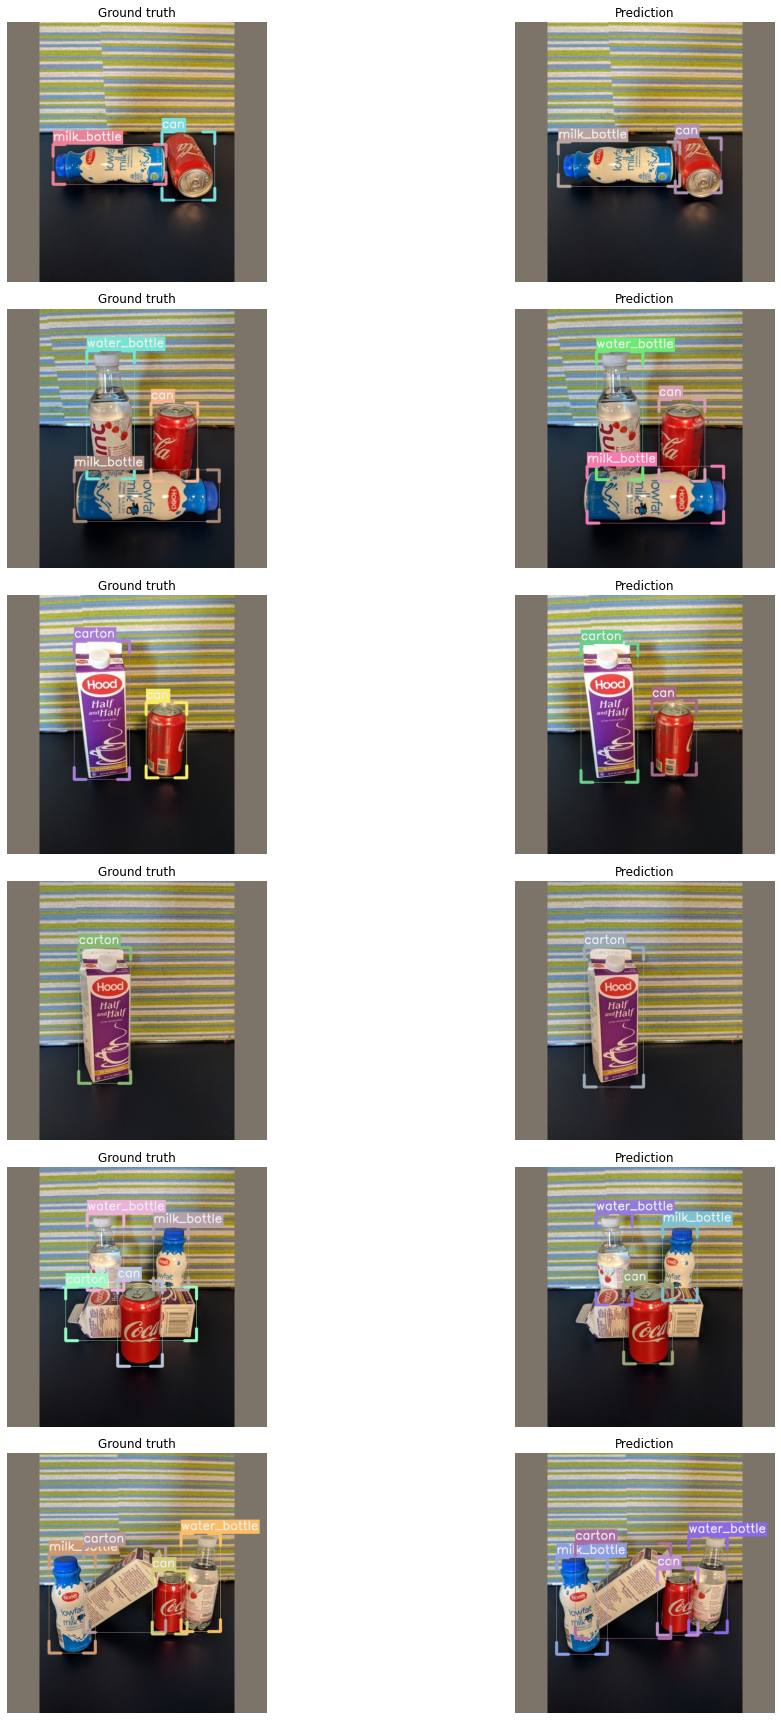

In [ ]:
show_preds(
    samples=samples[:6],
    preds=preds[:6],
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    ncols=3,
)

## Saving Model on Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = Path('/content/gdrive/My Drive/')

Mounted at /content/gdrive


In [ ]:
torch.save(model.state_dict(), root_dir/'icevision/models/fridge/fridge_restnet_fpn50.pth')

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).